# VKLIKE TF2 (EfficientNet)

For B0 to B7 base models, the input shapes are different. Here is a list of input shape expected for each model:

| Base model    | resolution |
|---------------|------------|
| EfficientNetB0 | 224        |
| EfficientNetB1 | 240        |
| EfficientNetB2 | 260        |
| EfficientNetB3 | 300        |
| EfficientNetB4 | 380        |
| EfficientNetB5 | 456        |
| EfficientNetB6 | 528        |
| EfficientNetB7 | 600        |

In [1]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!cp /content/gdrive/MyDrive/DATA/20220424-vklike_dataset.zip /content
!unzip -qq -d /content /content/20220424-vklike_dataset.zip
!ls /content

20220424-vklike_dataset  20220424-vklike_dataset.zip  gdrive  sample_data


In [3]:
!ls /content/20220424-vklike_dataset

dislike  like  lobe-bf07e5dd7a5d4a398e09d19ce4215f74.csv


In [208]:
import tensorflow as tf

from typing import List, Dict, Tuple, Optional
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
from tqdm import tqdm
from pathlib import Path
from PIL import Image

In [67]:
DATA = Path('/content/20220424-vklike_dataset')

In [71]:
def create_dataset_df(path: Path) -> pd.DataFrame:
    res = []
    for file in path.glob('**/*.jpg'):
        img = Image.open(file)
        res.append({
            'file': file.name,
            'label': file.parent.name,
            'width': img.width,
            'height': img.height,
        })
    return pd.DataFrame(res)


df = create_dataset_df(DATA)
df.head()

,file,label,width,height
0,4ea10ce6cec080d17918d0ad0aa42639a26e2b0d36b7d6...,dislike,244,244
1,fc83f0f694868775106f9bd6a51a24237a1b3335e9a97e...,dislike,244,244
2,4e948c918ca210e4fbb817135bd224cbd22ca87f967814...,dislike,1224,1632
3,828c9cddd8b025b8d9b04f1d4507660a121cb0bf3a5e52...,dislike,1224,1632
4,32b7b6d62cde5cb388ab44f9807053fcc60992cc210bd6...,dislike,1280,650


In [73]:
df['width'].describe()

count    8444.000000
mean      662.556608
std       495.164638
min       194.000000
25%       244.000000
50%       510.000000
75%       810.000000
max      2560.000000
Name: width, dtype: float64

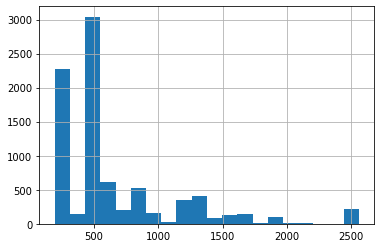

In [75]:
df['width'].hist(bins=20)

In [76]:
SEED = 1337
IMAGE_SIZE = (300, 300)
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2

# Keras will automatically create labels (0 - dislike, 1 - like)

training_images = tf.keras.preprocessing.image_dataset_from_directory(
    DATA,
    validation_split = VALIDATION_SPLIT,
    subset = "training",
    seed = SEED,
    image_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE,
    crop_to_aspect_ratio=False
)

validation_images = tf.keras.preprocessing.image_dataset_from_directory(
    DATA,
    validation_split = VALIDATION_SPLIT,
    subset = "validation",
    seed = SEED,
    image_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE,
    crop_to_aspect_ratio=False
)

Found 8444 files belonging to 2 classes.
Using 6756 files for training.
Found 8444 files belonging to 2 classes.
Using 1688 files for validation.


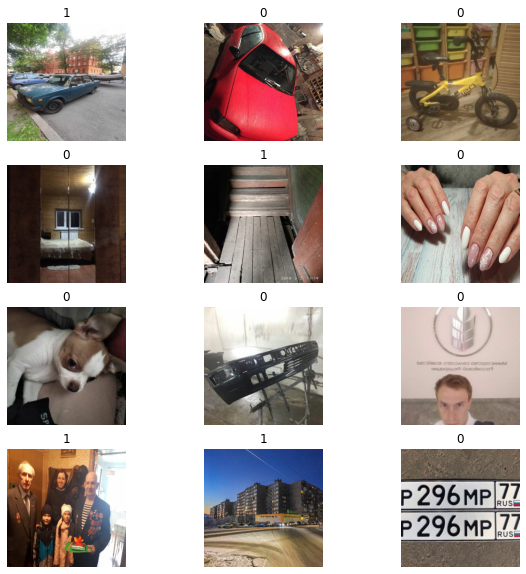

In [81]:
plt.figure(figsize=(10, 10))
for images, labels in training_images.take(1):
    for i in range(12):
        ax = plt.subplot(4, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [82]:
# Create augmentaion layer for model
img_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    tf.keras.layers.RandomContrast(0.1, seed=42),
])

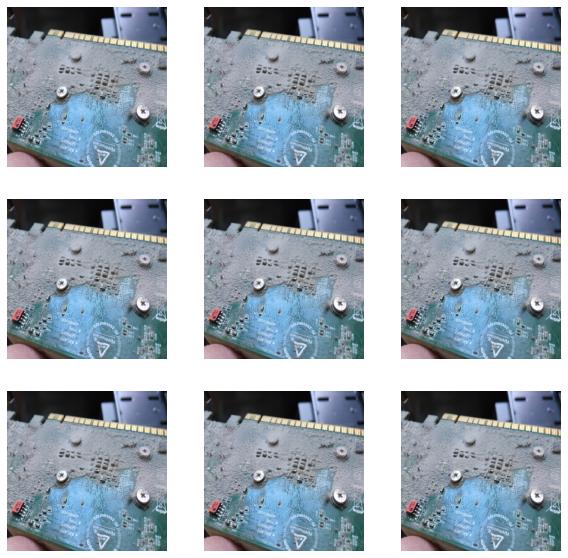

In [83]:
# Let see how augmentaion works
plt.figure(figsize=(10, 10))
for images, _ in training_images.take(1):
    for i in range(9):
        augmented_images = img_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [84]:
# Prepare inputs
# prefetch may in some situation improve performance
training_images = training_images.prefetch(buffer_size=32)
validation_images = validation_images.prefetch(buffer_size=32)

In [85]:
def build_model(input_shape, num_classes: int, dropout_rate: float):
    inputs = tf.keras.layers.Input(shape=input_shape)
    x = img_augmentation(inputs)
    cnn = tf.keras.applications.EfficientNetB3(
        input_tensor=x,
        include_top=False,
        weights="imagenet",
    )

    # Freeze the pretrained weights
    cnn.trainable = False

    # Rebuild top
    x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(cnn.output)
    x = tf.keras.layers.BatchNormalization()(x)

    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes
    x = tf.keras.layers.Dropout(dropout_rate, name="top_dropout")(x)
    outputs = tf.keras.layers.Dense(units, activation=activation, name="pred")(x)

    return tf.keras.Model(inputs, outputs, name="EfficientNet")

In [86]:
# Create an instance of model
model = build_model(
    input_shape=IMAGE_SIZE + (3,),
    num_classes=2,
    dropout_rate=0.5,
)

43950080/43941136 [==============================] - 1s 0us/step


In [88]:
# Visualize model
# tf.keras.utils.plot_model(model, show_shapes = True)

In [90]:
# We will save weight of model after each epoch of training in Keras (h5) format.
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("vklike_model/epoch_{epoch}.h5")
]

# We unfreeze the top 20 layers while leaving BatchNorm layers frozen
for layer in model.layers[-20:]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

# optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3) # for training head layer
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4) # for training last 20 layers

model.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.summary()

Model: "EfficientNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential_5 (Sequential)      (None, 300, 300, 3)  0           ['input_6[0][0]']                
                                                                                                  
 rescaling_3 (Rescaling)        (None, 300, 300, 3)  0           ['sequential_5[0][0]']           
                                                                                                  
 normalization_1 (Normalization  (None, 300, 300, 3)  7          ['rescaling_3[0][0]'] 

In [91]:
EPOCHS = 25

history = model.fit(
    training_images, epochs=EPOCHS, callbacks=callbacks, validation_data=validation_images
)

Epoch 1/25
212/212 [==============================] - 164s 698ms/step - loss: 0.4144 - accuracy: 0.8310 - val_loss: 0.2587 - val_accuracy: 0.8928
Epoch 2/25
212/212 [==============================] - 143s 669ms/step - loss: 0.2844 - accuracy: 0.8891 - val_loss: 0.2638 - val_accuracy: 0.8975
Epoch 3/25
212/212 [==============================] - 143s 668ms/step - loss: 0.2303 - accuracy: 0.9082 - val_loss: 0.2461 - val_accuracy: 0.9070
Epoch 4/25
212/212 [==============================] - 143s 668ms/step - loss: 0.1936 - accuracy: 0.9201 - val_loss: 0.2497 - val_accuracy: 0.9135
Epoch 5/25
212/212 [==============================] - 143s 669ms/step - loss: 0.1728 - accuracy: 0.9307 - val_loss: 0.2524 - val_accuracy: 0.9147
Epoch 6/25
212/212 [==============================] - 143s 668ms/step - loss: 0.1543 - accuracy: 0.9420 - val_loss: 0.2519 - val_accuracy: 0.9111
Epoch 7/25
212/212 [==============================] - 142s 667ms/step - loss: 0.1189 - accuracy: 0.9534 - val_loss: 0.2654 -

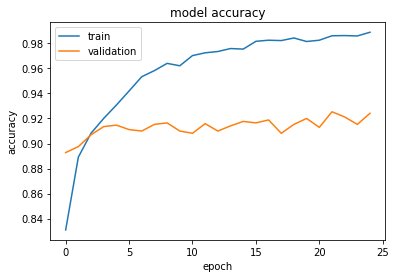

In [92]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(history)

In [23]:
# Save TensorFlow model (saved_model.pb + variables/)
model.save("vklike_model")

INFO:tensorflow:Assets written to: vklike_model/assets


In [ ]:
# Load whole model from disk in TensorFlow format (saved_model.pb + variables/)
# model = tf.keras.models.load_model("vklike_model")

# Load weights in Keras format(h5)
# model.load_weights('vklike_model/epoch_25.h5')

In [94]:
def predict(mode, img: Image) -> float:
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    return predictions[0][0]

In [99]:
def load_image(url: str, size: Tuple[int, int]) -> Image:
    res = requests.get(url, stream=True)
    img = Image.open(res.raw)
    return img.resize(IMAGE_SIZE)

Image is LIKE with 0.9999995231628418 confidence


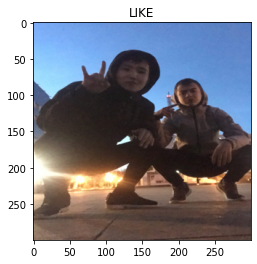

In [106]:
img = load_image(
    url = 'https://sun9-77.userapi.com/impg/Xv8dJh4OnSgY2ZAc04-_L7SokiJCxmwDKv2PrQ/_htEJkgpA0M.jpg?size=811x1080&quality=96&sign=1641ab517a74fa2e23ef2b0d2acf9ecf&c_uniq_tag=xhbHQL3zHtK59Dfuyz47cQPIIrBtDgIkP_VVRCPXoR0&type=album',
    size = IMAGE_SIZE,
)
score = predict(model, img)

plt.imshow(img)
label = "LIKE" if score > 0.99 else "DISLIKE"
plt.title(f"{label}")

print(f"Image is LIKE with {score} confidence")

## Check

In [108]:
!cp -r /content/gdrive/MyDrive/DATA/20210119-vk_volkhov_photos /content/20210119-vk_volkhov_photos
!ls -l /content/20210119-vk_volkhov_photos | wc -l

2


In [206]:
class VklikePredictor:
    def __init__(self, model, image_size: Tuple[int, int], batch_size: int) -> None:
        self.model = model
        self.image_size = image_size
        self.batch_size = batch_size

    def __call__(self, files: List[Path]):
        total = self.calc_batches(files)
        result = []
        for chunk in tqdm(self.iter_batch(iter(files)), total=total):
            filenames = []
            images = []
            for f in chunk:
                img = tf.keras.preprocessing.image.load_img(
                    f, target_size=self.image_size,
                )
                img_array = tf.keras.preprocessing.image.img_to_array(img)
                images.append(img_array)
                filenames.append(f.name)
            batch = tf.stack(images, axis=0)
            predictions = model(batch)
            for i, filename in enumerate(filenames):
                score = predictions[i][0].numpy()
                result.append({
                    "filename": filename,
                    "score": score,
                })
        return result
    
    def calc_batches(self, items: List) -> int:
        return int(np.ceil(len(items) / self.batch_size))

    def iter_batch(self, items):
        while True:
            chunk = []
            for i in range(self.batch_size):
                try:
                    x = next(items)
                    chunk.append(x)
                except StopIteration:
                    return chunk
            yield chunk
            

In [209]:
from random import shuffle
test_path = Path('/content/20210119-vk_volkhov_photos/20210119-vk_volkhov_photos')
xs = list(test_path.glob('*.jpg'))
xs = xs[:1000]
shuffle(xs)

predict = VklikePredictor(
    model=model,
    image_size=IMAGE_SIZE,
    batch_size=32,
)
volhov = predict(xs)

 97%|█████████▋| 31/32.0 [02:07<00:04,  4.10s/it]


In [211]:
df_volhov = pd.DataFrame(volhov)
df_volhov.sample(10)

,filename,score
58,-176228195_456239051.jpg,0.000152
115,-86743309_457397133.jpg,0.000013
140,-63196287_457263401.jpg,0.997269
786,-24831014_396678954.jpg,0.000028
811,-86743309_457398036.jpg,0.002350
217,-156060927_457240109.jpg,0.000005
847,107165230_371971923.jpg,0.999566
693,-2016597_457241837.jpg,0.999980
215,7907752_456240015.jpg,0.008170
563,-86743309_456304900.jpg,0.001338


In [212]:
df_volhov.shape

(992, 2)

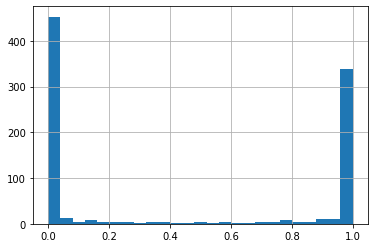

In [156]:
df_volhov['score'].hist(bins=25)

In [172]:
def resize_image(image: Image, size: Tuple[int, int]) -> Image:
    width, height = image.size
    if width != height:
        square_size = min(width, height)
        left = (width - square_size) / 2
        top = (height - square_size) / 2
        right = (width + square_size) / 2
        bottom = (height + square_size) / 2
        # Crop the center of the image
        image = image.crop((left, top, right, bottom))
    # now the image is square, resize it 
    w, h = size
    if image.width != w or image.height != h:
        return image.resize(size)
        # , Image.Resampling.LANCZOS)
    return image

In [199]:
def show_predicted(df):
    pad = 2
    plt.figure(figsize=(9, 12 + pad))
    for i, (_, row) in enumerate(df.iterrows()):
        img = test_path / row['filename']
        image = Image.open(img)
        image = resize_image(image, (300, 300))
        ax = plt.subplot(4, 3, i + 1)
        plt.imshow(image)
        s = str(row["score"])[:7]
        title = f"{img.name}\n({s})"
        plt.title(title)
        plt.axis("off")

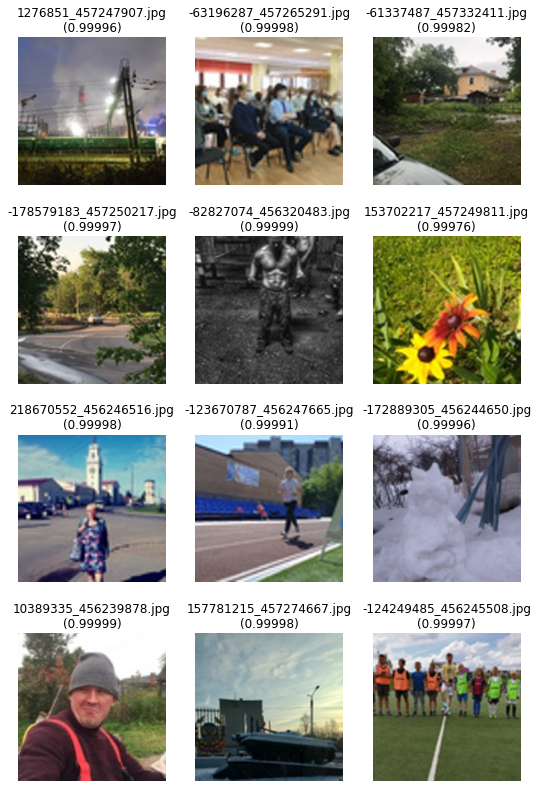

In [201]:
show_predicted(
    df_volhov[df_volhov['score'] > 0.999].sample(12)
)

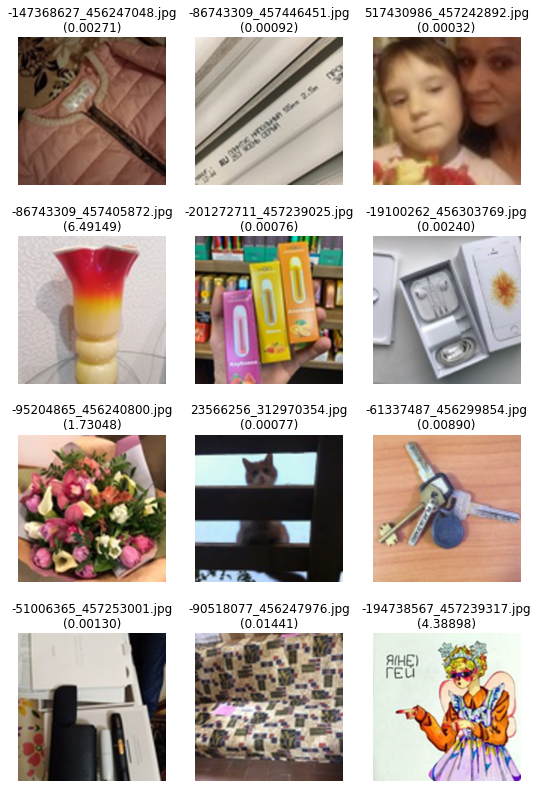

In [202]:
show_predicted(
    df_volhov[df_volhov['score'] < 0.05].sample(12)
)

(99, 2)

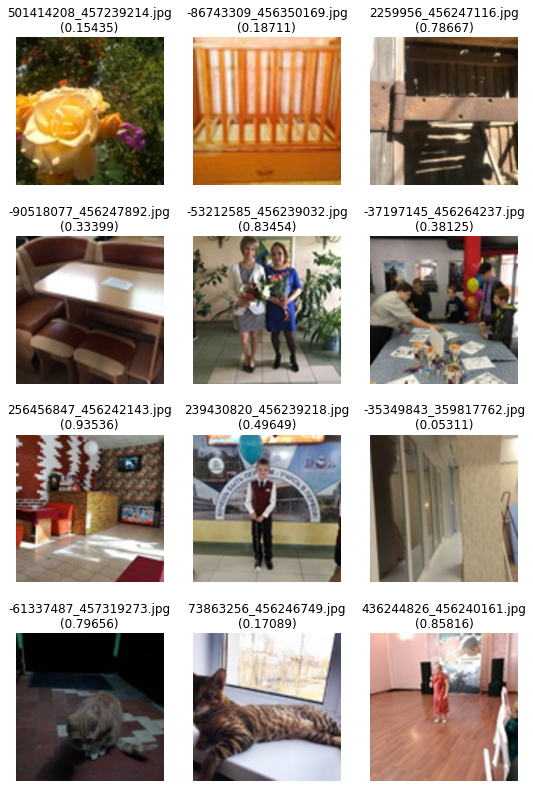

In [203]:
x = df_volhov[(df_volhov['score'] > 0.05) & (df_volhov['score'] < 0.95)]
show_predicted(
    x.sample(12)
)

x.shape

In [144]:
!wget http://94.228.125.103:8000/20220410-minvody_photos.zip

--2022-04-24 23:37:24--  http://94.228.125.103:8000/20220410-minvody_photos.zip
Connecting to 94.228.125.103:8000... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14784990825 (14G) [application/zip]
Saving to: ‘20220410-minvody_photos.zip’

20410-minvody_photo  20%[===>                ]   2.83G  10.1MB/s    eta 21m 30s^C
